In [1]:
import fenics as fn
import numpy as np
import matplotlib.pyplot as plt
from mshr import *
import pandas as pd
%matplotlib widget
import ipywidgets as widgets

# Define the .xml file path
xml_mesh_file = "/home/luca/Desktop/Research/Rooney Paper Sim/Rooney Paper Sim/Rooney Geometry/Rooney3D.xml"

# Create a Mesh object and read the mesh from the .xml file
mesh = fn.Mesh(xml_mesh_file)
# Read subdomains and boundaries
subdomains =  fn.MeshFunction("size_t", mesh,'/home/luca/Desktop/Research/Rooney Paper Sim/Rooney Paper Sim/Rooney Geometry/Rooney3D_physical_region.xml')
boundaries = fn.MeshFunction('size_t', mesh,'/home/luca/Desktop/Research/Rooney Paper Sim/Rooney Paper Sim/Rooney Geometry/Rooney3D_facet_region.xml')

# Define Material Parameters

In [2]:
# Define object
class Lambda(fn.UserExpression):
    # Define initializer method, it will be called when an instance of this class is created
    def __init__(self, markers, **kwargs):
        # Our boundary identifier data will be passed to "markers"
        self.markers = markers
        super().__init__(**kwargs)
        
    def eval_cell(self, values, x, cell):
        # Ge (index = 298) Lambda = 49
        if self.markers[cell.index] == 298:
            values[0] = 49.0
        # Al2O3 (index = 296) Lambda = 63.3
        elif self.markers[cell.index] == 296:
            values[0] = 63.3
        # Al (index = 295) Lambda = 61.37
        elif self.markers[cell.index] == 295:
            values[0] = 61.37
        # GeSi (index = 297) Lambda = 52.2
        elif self.markers[cell.index] == 297:
            values[0] = 52.2
        # There shouldn't any more physical regions, in case we make mistake in geometry, we let their Lambda be 0
        else:
            values[0] = 0

# Create a Lambda class object that represents the first Lame parameter of each region
lam = Lambda(subdomains, degree=0)

In [3]:
# Define object
class Mu(fn.UserExpression):
    # Define initializer method, it will be called when an instance of this class is created
    def __init__(self, markers, **kwargs):
        # Our boundary identifier data will be passed to "markers"
        self.markers = markers
        super().__init__(**kwargs)
        
    def eval_cell(self, values, x, cell):
        # Ge (index = 298) Mu = 68.8
        if self.markers[cell.index] == 298:
            values[0] = 68.8
        # Al2O3 (index = 296) Mu = 68.5
        elif self.markers[cell.index] == 296:
            values[0] = 68.5
        # Al (index = 295) Mu = 30.9
        elif self.markers[cell.index] == 295:
            values[0] = 30.9
        # GeSi (index = 297) Mu = 71.1
        elif self.markers[cell.index] == 297:
            values[0] = 71.1
        # There shouldn't any more physical regions, in case we make mistake in geometry, we let their Lambda be 0
        else:
            values[0] = 0

# Create a Mu class object that represents the second Lame parameter of each region
mu = Mu(subdomains, degree=0)

In [4]:
# Define object
class Alpha(fn.UserExpression):
    # Define initializer method, it will be called when an instance of this class is created
    def __init__(self, markers, **kwargs):
        # Our boundary identifier data will be passed to "markers"
        self.markers = markers
        super().__init__(**kwargs)
        
    def eval_cell(self, values, x, cell):
        # Ge (index = 270) alpha = 6.64
        if self.markers[cell.index] == 298:
            values[0] = 2.4 * 10**(-6)
        # Al2O3 (index = 272) alpha = 4.2
        elif self.markers[cell.index] == 296:
            values[0] = 0.8 * 10**(-6)
        # Al (index = 271) alpha = 24
        elif self.markers[cell.index] == 295:
            values[0] = 0.38 * 10**(-6)
        # GeSi (index = 269) alpha = 4.64
        elif self.markers[cell.index] == 297:
            values[0] = 4.7 * 10**(-6)
        # There shouldn't any more physical regions, in case we make mistake in geometry, we let their Lambda be 0
        else:
            values[0] = 0

# Create an Alpha class object that represents the linear thermal expansion coefficient of each region
alpha = Alpha(subdomains, degree=0)

# Thermal Problem

In [5]:
# Define function space for temperature on the mesh
VT = fn.FunctionSpace(mesh, "CG", 1)

# Define test and trial functions for the variational formulation
T_ = fn.TestFunction(VT)
dT = fn.TrialFunction(VT)

# Function to hold the computed temperature increase
Delta_T = fn.Function(VT, name="Temperature increase")

# Define the weak form of the heat equation
# Assuming steady-state heat conduction with no internal heat generation
aT = fn.dot(fn.grad(dT), fn.grad(T_)) * fn.dx  # Bilinear form
LT = fn.Constant(0) * T_ * fn.dx  # Linear form representing zero source terms

In [6]:
# Boundary condition: Temperature set to 300K at the outermost boundary
# The '100' identifies the part of the boundary to apply this condition
T_BC1 = fn.DirichletBC(VT, fn.Constant(280), boundaries, 299)
T_BC2 = fn.DirichletBC(VT, fn.Constant(280), boundaries, 300)

# List of boundary conditions
T_BCs = [T_BC1, T_BC2]

In [7]:
# Solve the thermal problem
fn.solve(aT == LT, Delta_T, T_BCs, solver_parameters = {
    'linear_solver': 'gmres',
    'preconditioner': 'hypre_amg'
})

Solving linear variational problem.


# Displacement Problem

In [8]:
def eps(v):
    """ Compute the symmetric gradient (strain tensor) in 3D. """
    return fn.sym(fn.grad(v))

def sigma(v, dT):
    """
    Args:
    - v: displacement field (Function)
    - dT: temperature change field (Function)
    
    Returns:
    - Stress tensor as a FEniCS TensorFunction
    """
    # Assume 'lam', 'mu', 'alpha' are defined globally or are accessible from the mesh
    # Compute the identity tensor in 3D
    I = fn.Identity(3)  # Appropriate for 3D problems

    # Thermal expansion term, computed with direct access to parameters
    thermal_expansion = alpha * (3 * lam + 2 * mu) * dT

    # Compute the full stress tensor incorporating both mechanical and thermal effects
    return (lam * fn.tr(eps(v)) - thermal_expansion) * I + 2.0 * mu * eps(v)

In [9]:
# Create a vector function space on the mesh for displacement field
Vu = fn.VectorFunctionSpace(mesh, 'CG', 2)

# Define trial and test functions for the variational formulation
du = fn.TrialFunction(Vu)
u_ = fn.TestFunction(Vu)

# Define the source term as zero (no external forces)
f = fn.Constant((0, 0, 0))

# Formulate the weak form of the internal energy (bilinear and linear forms)
Wint = fn.inner(sigma(du, Delta_T), eps(u_)) * fn.dx
aM = fn.lhs(Wint)  # Bilinear form
LM = fn.rhs(Wint) + fn.inner(f, u_) * fn.dx  # Linear form including external forces

# Apply Dirichlet boundary conditions (fixed displacement at outmost boundaries)
U_BC1 = fn.DirichletBC(Vu, fn.Constant((0., 0., 0.)), boundaries, 299) # Base
U_BC2 = fn.DirichletBC(Vu, fn.Constant((0., 0., 0.)), boundaries, 300) # Top

# List of boundary conditions
U_BCs = [U_BC1, U_BC2]

In [10]:
# Solve the the displacement
u = fn.Function(Vu, name="Displacement")
fn.solve(aM == LM, u, U_BCs, solver_parameters = {
    'linear_solver': 'gmres',
    'preconditioner': 'hypre_amg'
})

Solving linear variational problem.


# Extract Numerical Solution

In [12]:
# Calculate strain
strain_tensor = eps(u)  # eps is as defined before

# Define projection space
V_scalar = fn.FunctionSpace(mesh, 'CG', 1)  # Scalar function space for computed values

## yy-xx Component

In [13]:
# Component of interest, for example eps_yy-xx
strain_component = strain_tensor[1, 1]-strain_tensor[0, 0]

# Project this component onto the function space
strain_projected = fn.project(strain_component, V_scalar)

# Define the z-coordinate of the plane
z_coord = -60  # Adjust to your needs

# Create grid of points in the xy-plane at z_coord
x_values = np.linspace(-500, 500, num=2000)  # Adjust the range based on your domain
y_values = np.linspace(-410, 590, num=2000)
X, Y = np.meshgrid(x_values, y_values)
num_x, num_y = X.shape

# Prepare to store the results
strain_values = np.zeros((num_x, num_y))

for i in range(num_x):
    for j in range(num_y):
        point = fn.Point(X[i, j], Y[i, j], z_coord)
        try:
            strain_values[i, j] = strain_projected(point)
        except Exception as e:
            strain_values[i, j] = np.nan  # Handle points outside the domain or other errors

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


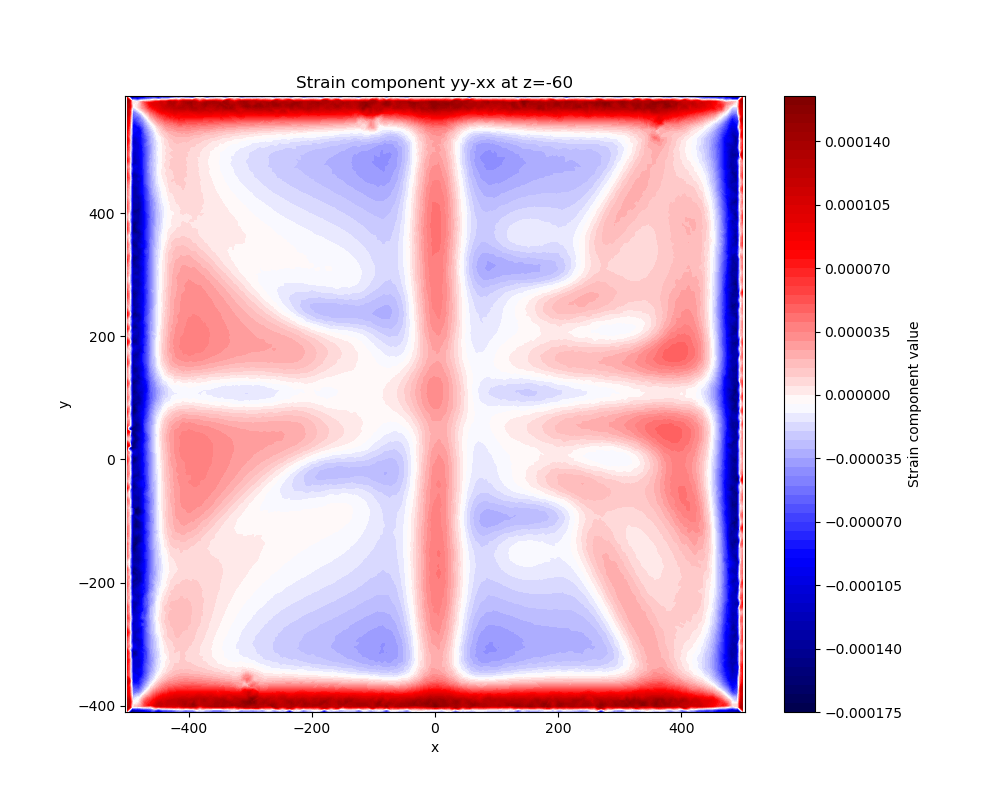

In [17]:
# Plot to verify that we got the correct value
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, strain_values, levels=70, cmap='seismic')
plt.colorbar(contour, label='Strain component value')
plt.title(f'Strain component yy-xx at z={z_coord}')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

In [18]:
# Create a DataFrame containning coordinate data and the corresponding strain component value
df = pd.DataFrame({
    'x': X.flatten(),
    'y': Y.flatten(),
    'strain_value': strain_values.flatten()
})

# Save to a CSV file
df.to_csv("strain_yy-xx data.csv", index=False)

## xz Component

In [19]:
# Component of interest, for example eps_xz
strain_component = strain_tensor[0, 2]

# Project this component onto the function space
strain_projected = fn.project(strain_component, V_scalar)

# Define the z-coordinate of the plane
z_coord = -60  # Adjust to your needs

# Create grid of points in the xy-plane at z_coord
x_values = np.linspace(-500, 500, num=2000)  # Adjust the range based on your domain
y_values = np.linspace(-410, 590, num=2000)
X, Y = np.meshgrid(x_values, y_values)
num_x, num_y = X.shape

# Prepare to store the results
strain_values = np.zeros((num_x, num_y))

for i in range(num_x):
    for j in range(num_y):
        point = fn.Point(X[i, j], Y[i, j], z_coord)
        try:
            strain_values[i, j] = strain_projected(point)
        except Exception as e:
            strain_values[i, j] = np.nan  # Handle points outside the domain or other errors

Calling FFC just-in-time (JIT) compiler, this may take some time.


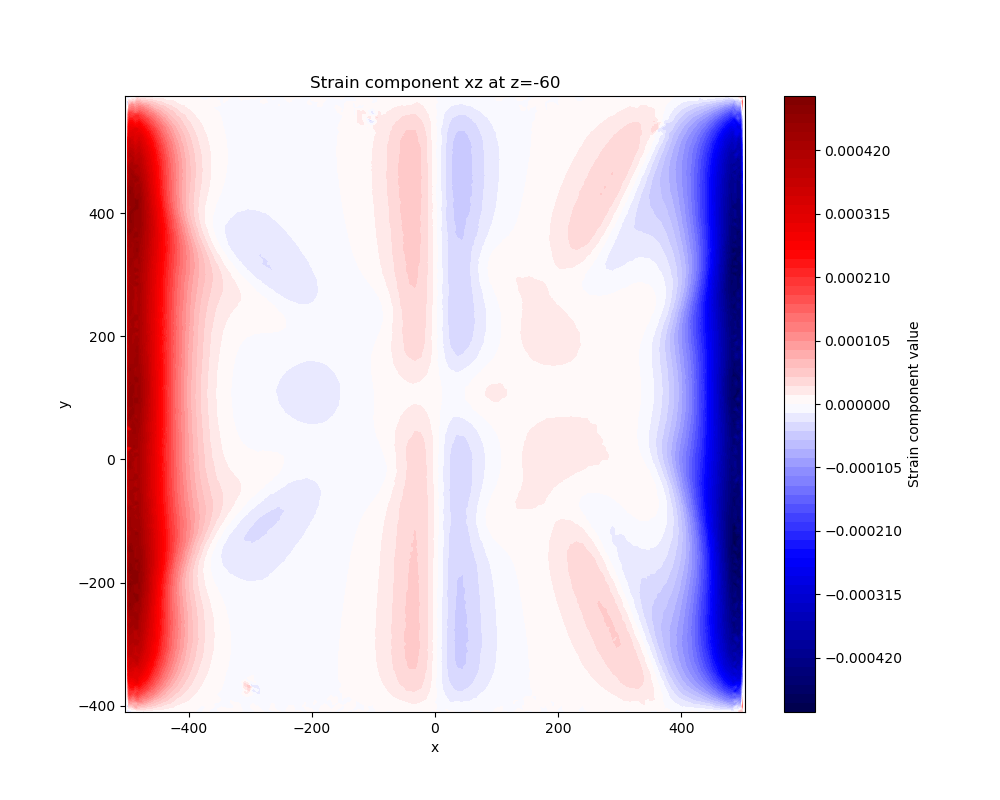

In [21]:
# Plot to verify that we got the correct value
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, strain_values, levels=70, cmap='seismic')
plt.colorbar(contour, label='Strain component value')
plt.title(f'Strain component xz at z={z_coord}')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

In [22]:
# Create a DataFrame containning coordinate data and the corresponding strain component value
df = pd.DataFrame({
    'x': X.flatten(),
    'y': Y.flatten(),
    'strain_value': strain_values.flatten()
})

# Save to a CSV file
df.to_csv("strain_xz data.csv", index=False)

## yz Component

In [26]:
# Component of interest, for example eps_yz
strain_component = strain_tensor[1, 2]

# Project this component onto the function space
strain_projected = fn.project(strain_component, V_scalar)

# Define the z-coordinate of the plane
z_coord = -60  # Adjust to your needs

# Create grid of points in the xy-plane at z_coord
x_values = np.linspace(-500, 500, num=2000)  # Adjust the range based on your domain
y_values = np.linspace(-410, 590, num=2000)
X, Y = np.meshgrid(x_values, y_values)
num_x, num_y = X.shape

# Prepare to store the results
strain_values = np.zeros((num_x, num_y))

for i in range(num_x):
    for j in range(num_y):
        point = fn.Point(X[i, j], Y[i, j], z_coord)
        try:
            strain_values[i, j] = strain_projected(point)
        except Exception as e:
            strain_values[i, j] = np.nan  # Handle points outside the domain or other errors

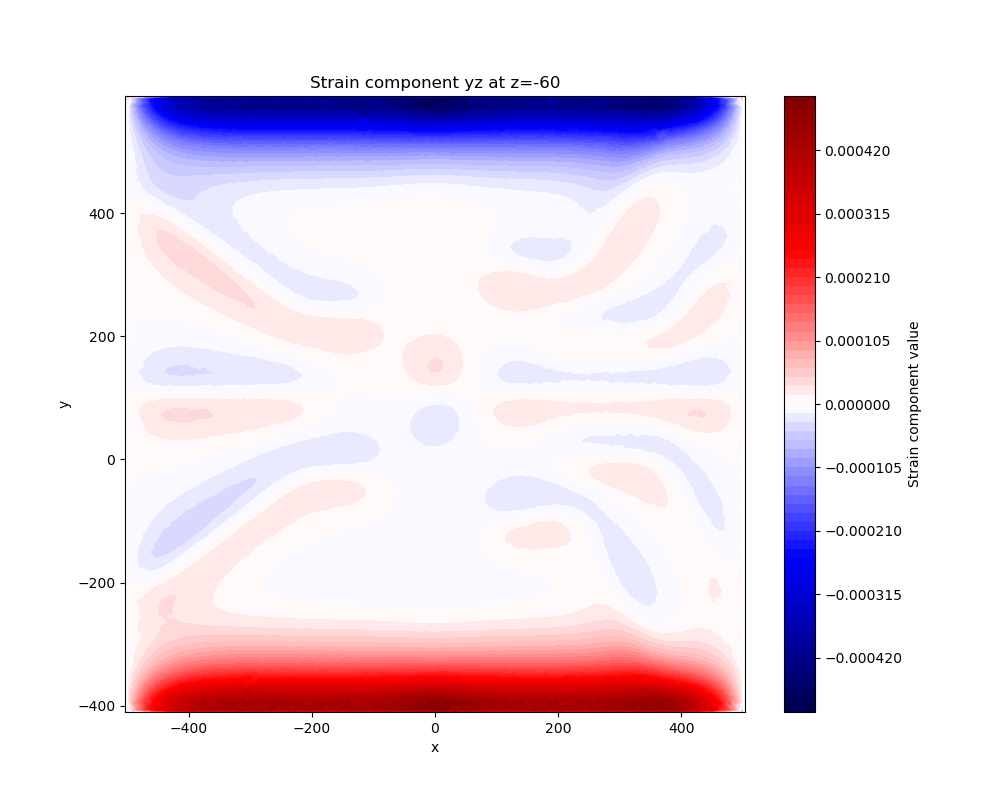

In [27]:
# Plot to verify that we got the correct value
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, strain_values, levels=70, cmap='seismic')
plt.colorbar(contour, label='Strain component value')
plt.title(f'Strain component yz at z={z_coord}')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

In [28]:
# Create a DataFrame containning coordinate data and the corresponding strain component value
df = pd.DataFrame({
    'x': X.flatten(),
    'y': Y.flatten(),
    'strain_value': strain_values.flatten()
})

# Save to a CSV file
df.to_csv("strain_yz data.csv", index=False)

## xy Component

In [30]:
# Component of interest, for example eps_xy
strain_component = strain_tensor[0, 1]

# Project this component onto the function space
strain_projected = fn.project(strain_component, V_scalar)

# Define the z-coordinate of the plane
z_coord = -60  # Adjust to your needs

# Create grid of points in the xy-plane at z_coord
x_values = np.linspace(-500, 500, num=2000)  # Adjust the range based on your domain
y_values = np.linspace(-410, 590, num=2000)
X, Y = np.meshgrid(x_values, y_values)
num_x, num_y = X.shape

# Prepare to store the results
strain_values = np.zeros((num_x, num_y))

for i in range(num_x):
    for j in range(num_y):
        point = fn.Point(X[i, j], Y[i, j], z_coord)
        try:
            strain_values[i, j] = strain_projected(point)
        except Exception as e:
            strain_values[i, j] = np.nan  # Handle points outside the domain or other errors

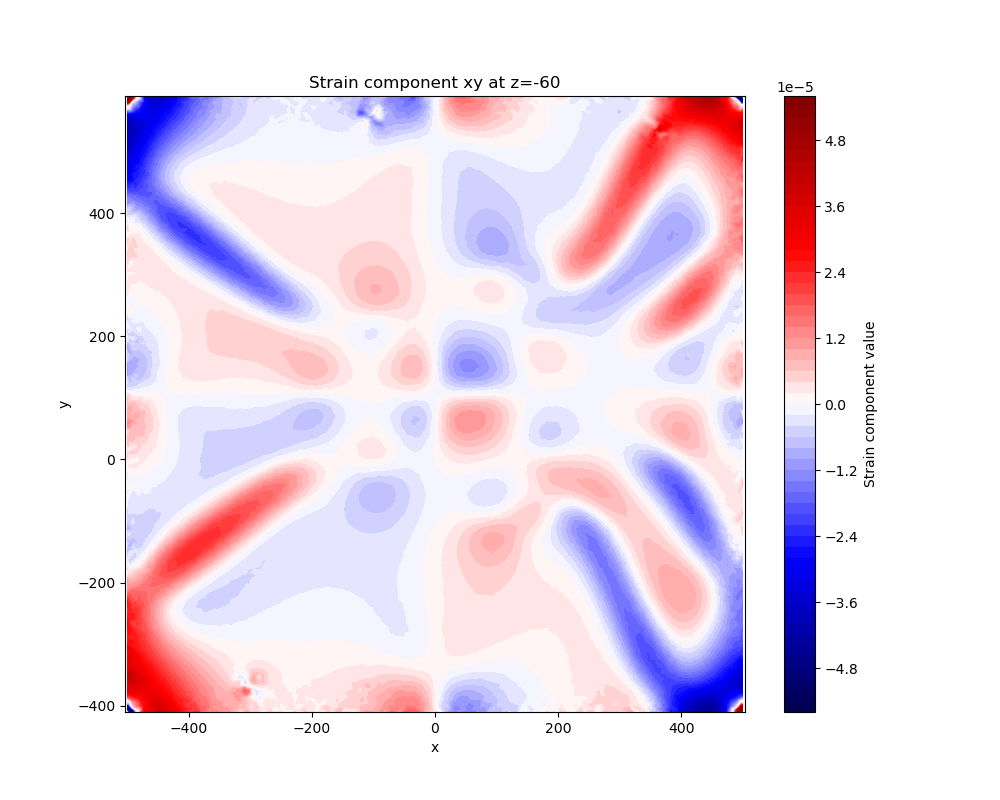

In [31]:
# Plot to verify that we got the correct value
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, strain_values, levels=70, cmap='seismic')
plt.colorbar(contour, label='Strain component value')
plt.title(f'Strain component xy at z={z_coord}')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

In [32]:
# Create a DataFrame containning coordinate data and the corresponding strain component value
df = pd.DataFrame({
    'x': X.flatten(),
    'y': Y.flatten(),
    'strain_value': strain_values.flatten()
})

# Save to a CSV file
df.to_csv("strain_xy data.csv", index=False)